In [8]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [9]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [20]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

print(Measurement)
print(Station)

<class 'sqlalchemy.ext.automap.measurement'>
<class 'sqlalchemy.ext.automap.station'>


In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [27]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2016-08-23', '2017-08-23'))

[(58.0, 74.59058295964125, 87.0)]


In [78]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

trip = calc_temps('2017-08-01', '2017-08-07')

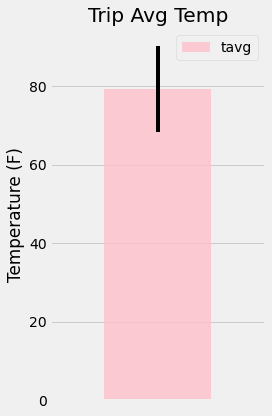

In [79]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip = pd.DataFrame(trip, columns=['tmin', 'tavg', 'tmax'])

trip.plot.bar(
    y = 'tavg', 
    yerr = (trip['tmax'] - trip['tmin']), 
    title = 'Trip Avg Temp', 
    alpha = 0.8, 
    color = 'pink',
    figsize = (4,6))

plt.xticks(np.arange(1, 1.0))
plt.ylabel("Temperature (F)")
plt.tight_layout()
plt.savefig('./year.png')
plt.show()

### Daily Rainfall Average

In [81]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start = '2017-08-01'
end = '2017-08-07'

def rainfall(start, end):
    columns = [
        Measurement.station,
        Station.name,  
        Measurement.prcp,
        Station.latitude, 
        Station.longitude, 
        Station.elevation
        ]

    return session.query(*columns
    ).filter(Measurement.station == Station.station
    ).filter(Measurement.date >= start
    ).filter(Measurement.date <= end
    ).group_by(Station.name
    ).order_by(Measurement.prcp.desc()).all()
    
df = rainfall(start, end)
df = pd.DataFrame(df).sort_values('prcp')
df

,station,name,prcp,latitude,longitude,elevation
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.00,21.33556,-157.71139,19.5
3,USC00519281,"WAIHEE 837.5, HI US",0.00,21.45167,-157.84889,32.9
1,USC00519397,"WAIKIKI 717.2, HI US",0.02,21.27160,-157.81680,3.0
0,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.12,21.52130,-157.83740,7.0
4,USC00516128,"MANOA LYON ARBO 785.2, HI US",NaN,21.33310,-157.80250,152.4


### Daily Temperature Normals

In [82]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [86]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
trip_dates = pd.date_range(start_date, end_date, freq='D')

# Strip off the year and save a list of strings in the format %m-%d
trip_yearless = trip_dates.strftime('%m-%d')


# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in trip_yearless:
    normals.append(*daily_normals(date))
    
normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [105]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
trip_df['date'] = trip_yearless
trip_df.set_index(['date'],inplace=True)
trip_df

,tmin,tavg,tmax
date,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


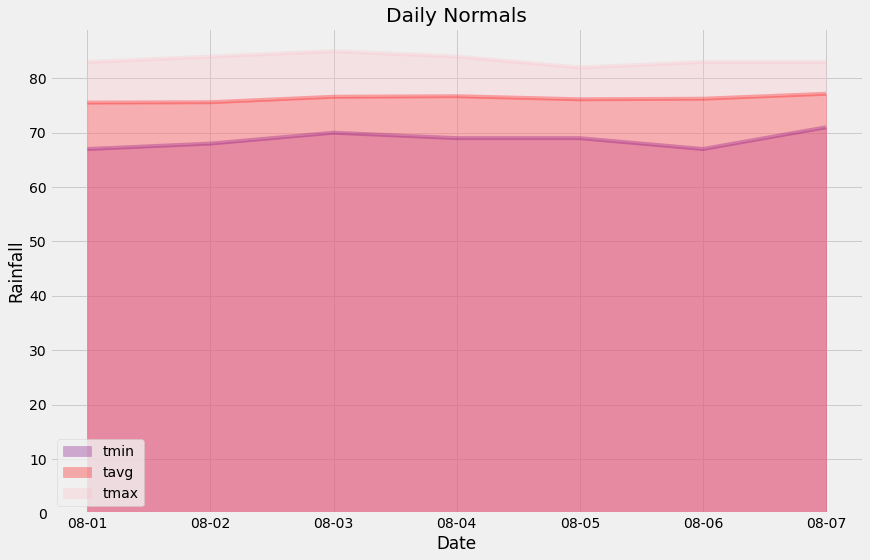

In [106]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(
    kind = 'area', 
    color = ('purple','red','pink'), 
    alpha = 0.3,
    stacked = False, 
    x_compat = True, 
    title = 'Daily Normals',
    figsize = (12, 8)
    )
plt.tight_layout()
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.savefig("./TripAvgRain.png")

## Close Session

In [104]:
session.close()